# ImageNet Transfer Learning Using EfficientNet

This notebook was run in Kaggle to provide GPU acceleration. The model being used has been trained in the other notebook in this folder, and the .h5 file is stored on kaggle and my laptop.

The model achieves ~86.7% Top1 accuracy, precision, recall, MCC and f1-scores. It achieves a decent 0.6 log loss and a very high Top3 accuracy of 99-96%.

The ROC and misclassification reports show the model has achieved high degree of feature richness, separability and accuracy. Most AUC values are over 0.98, and most misclassifications were between semantically similar classes (eg. types of sharks).

### Implemented by Pratham Shah, 240905614, for the Cryptonite Research Taskphase

## Imports

Note the data dictionary: I copy-pasted it in from the kaggle dataset where ImageNet100 was available.

In [20]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
from sklearn.calibration import label_binarize
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, auc, roc_curve, log_loss, accuracy_score, precision_score, f1_score, recall_score

data = {"n01968897": "chambered nautilus, pearly nautilus, nautilus", "n01770081": "harvestman, daddy longlegs, Phalangium opilio", "n01818515": "macaw", "n02011460": "bittern", "n01496331": "electric ray, crampfish, numbfish, torpedo", "n01847000": "drake", "n01687978": "agama", "n01740131": "night snake, Hypsiglena torquata", "n01537544": "indigo bunting, indigo finch, indigo bird, Passerina cyanea", "n01491361": "tiger shark, Galeocerdo cuvieri", "n02007558": "flamingo", "n01735189": "garter snake, grass snake", "n01630670": "common newt, Triturus vulgaris", "n01440764": "tench, Tinca tinca", "n01819313": "sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita", "n02002556": "white stork, Ciconia ciconia", "n01667778": "terrapin", "n01755581": "diamondback, diamondback rattlesnake, Crotalus adamanteus", "n01924916": "flatworm, platyhelminth", "n01751748": "sea snake", "n01984695": "spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish", "n01729977": "green snake, grass snake", "n01614925": "bald eagle, American eagle, Haliaeetus leucocephalus", "n01608432": "kite", "n01443537": "goldfish, Carassius auratus", "n01770393": "scorpion", "n01855672": "goose", "n01560419": "bulbul", "n01592084": "chickadee", "n01914609": "sea anemone, anemone", "n01582220": "magpie", "n01667114": "mud turtle", "n01985128": "crayfish, crawfish, crawdad, crawdaddy", "n01820546": "lorikeet", "n01773797": "garden spider, Aranea diademata", "n02006656": "spoonbill", "n01986214": "hermit crab", "n01484850": "great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias", "n01749939": "green mamba", "n01828970": "bee eater", "n02018795": "bustard", "n01695060": "Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis", "n01729322": "hognose snake, puff adder, sand viper", "n01677366": "common iguana, iguana, Iguana iguana", "n01734418": "king snake, kingsnake", "n01843383": "toucan", "n01806143": "peacock", "n01773549": "barn spider, Araneus cavaticus", "n01775062": "wolf spider, hunting spider", "n01728572": "thunder snake, worm snake, Carphophis amoenus", "n01601694": "water ouzel, dipper", "n01978287": "Dungeness crab, Cancer magister", "n01930112": "nematode, nematode worm, roundworm", "n01739381": "vine snake", "n01883070": "wombat", "n01774384": "black widow, Latrodectus mactans", "n02037110": "oystercatcher, oyster catcher", "n01795545": "black grouse", "n02027492": "red-backed sandpiper, dunlin, Erolia alpina", "n01531178": "goldfinch, Carduelis carduelis", "n01944390": "snail", "n01494475": "hammerhead, hammerhead shark", "n01632458": "spotted salamander, Ambystoma maculatum", "n01698640": "American alligator, Alligator mississipiensis", "n01675722": "banded gecko", "n01877812": "wallaby, brush kangaroo", "n01622779": "great grey owl, great gray owl, Strix nebulosa", "n01910747": "jellyfish", "n01860187": "black swan, Cygnus atratus", "n01796340": "ptarmigan", "n01833805": "hummingbird", "n01685808": "whiptail, whiptail lizard", "n01756291": "sidewinder, horned rattlesnake, Crotalus cerastes", "n01514859": "hen", "n01753488": "horned viper, cerastes, sand viper, horned asp, Cerastes cornutus", "n02058221": "albatross, mollymawk", "n01632777": "axolotl, mud puppy, Ambystoma mexicanum", "n01644900": "tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui", "n02018207": "American coot, marsh hen, mud hen, water hen, Fulica americana", "n01664065": "loggerhead, loggerhead turtle, Caretta caretta", "n02028035": "redshank, Tringa totanus", "n02012849": "crane", "n01776313": "tick", "n02077923": "sea lion", "n01774750": "tarantula", "n01742172": "boa constrictor, Constrictor constrictor", "n01943899": "conch", "n01798484": "prairie chicken, prairie grouse, prairie fowl", "n02051845": "pelican", "n01824575": "coucal", "n02013706": "limpkin, Aramus pictus", "n01955084": "chiton, coat-of-mail shell, sea cradle, polyplacophore", "n01773157": "black and gold garden spider, Argiope aurantia", "n01665541": "leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea", "n01498041": "stingray", "n01978455": "rock crab, Cancer irroratus", "n01693334": "green lizard, Lacerta viridis", "n01950731": "sea slug, nudibranch", "n01829413": "hornbill", "n01514668": "cock"}

## Consolidating the 4 train subsets into 1

The training and valuation classes are not equal (25 and 100). Thus, I combined all the training classes into imagenet100/train_combined - and used that for training the final 100-output model.

In [ ]:
train_output = "/kaggle/working/imagenet100/train_combined" #one directory to store all the subclasses of imagenet100

os.makedirs(train_output, exist_ok=True)

for i in range(1, 5):
    subset_path = f"/kaggle/input/imagenet100/train.X{i}"

    for class_name in os.listdir(subset_path): #25 classes per each train
        src = f"{subset_path}/{class_name}"
        dst = f"{train_output}/{class_name}"

        if not os.path.exists(dst):
            shutil.copytree(src, dst)
            print(f"Copied: {class_name} from train.X{i}")
        else:
            print(f"Skipped: {class_name} already exists") #from a previous training

Copied: n01531178 from train.X1
Copied: n01440764 from train.X1
Copied: n01494475 from train.X1
Copied: n01950731 from train.X1
Copied: n01795545 from train.X1
Copied: n01632777 from train.X1
Copied: n02012849 from train.X1
Copied: n01775062 from train.X1
Copied: n02007558 from train.X1
Copied: n01484850 from train.X1
Copied: n01930112 from train.X1
Copied: n01984695 from train.X1
Copied: n02037110 from train.X1
Copied: n02018795 from train.X1
Copied: n01695060 from train.X1
Copied: n01978455 from train.X1
Copied: n01749939 from train.X1
Copied: n01824575 from train.X1
Copied: n01914609 from train.X1
Copied: n01833805 from train.X1
Copied: n01924916 from train.X1
Copied: n01665541 from train.X1
Copied: n01820546 from train.X1
Copied: n01687978 from train.X1
Copied: n01818515 from train.X1
Copied: n02058221 from train.X2
Copied: n01677366 from train.X2
Copied: n02077923 from train.X2
Copied: n01698640 from train.X2
Copied: n01592084 from train.X2
Copied: n01537544 from train.X2
Copied: 

## Image Augmentation and Batch-wise generation

In [3]:
augmentor = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,
    rotation_range = 30,
    zoom_range = 0.2,
    shear_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

train_gen = augmentor.flow_from_directory("/kaggle/working/imagenet100/train_combined", batch_size=32, target_size=(256, 256),)
val_gen = augmentor.flow_from_directory("/kaggle/input/imagenet100/val.X", batch_size=32, shuffle=False, target_size=(256, 256),)

Found 130000 images belonging to 100 classes.
Found 5000 images belonging to 100 classes.


## The Model

In [4]:
model = load_model("/kaggle/input/model-imagenet/best_model (4).h5")

2025-06-24 21:41:19.959679: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Performance Monitoring

In [5]:
predictions = model.predict(val_gen)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


157/157 ━━━━━━━━━━━━━━━━━━━━ 699s 4s/step


example of the cnn output showing probabilities:
[8.5016316e-01 2.4254823e-03 2.8299596e-03 6.7641176e-03 1.6182263e-03
 2.1801204e-03 1.0448059e-03 7.7978527e-04 1.2899558e-03 1.0241783e-03
 1.9798805e-03 1.7867933e-03 9.7862317e-04 1.6278538e-03 1.7732909e-03
 5.6642224e-04 1.2973142e-03 1.0508120e-03 2.1637434e-03 1.0332561e-03
 3.7848898e-03 1.2988740e-03 1.2662031e-03 5.3188275e-04 1.6938313e-03
 1.2286116e-03 1.3064982e-03 2.2057726e-03 6.3549605e-04 1.8431195e-03
 1.9597353e-03 2.4808755e-03 1.9817178e-03 1.4682673e-03 5.3830101e-04
 2.0620779e-03 1.1537242e-03 8.1393815e-04 1.1014863e-03 1.1939941e-03
 2.9094550e-03 1.9012936e-03 2.6898156e-03 1.1890857e-03 1.4447515e-03
 1.3519117e-03 2.5792792e-03 1.3780007e-03 1.5984752e-03 1.2985866e-03
 2.7528058e-03 1.5425334e-03 1.4817368e-03 2.5744515e-03 8.9974789e-04
 1.2278601e-03 7.0324488e-04 9.9751609e-04 1.2719586e-03 1.6763582e-03
 1.1209681e-03 9.9165959e-04 1.7328819e-03 1.3204750e-03 9.1509812e-04
 5.7216961e-04 1.2053773e-03

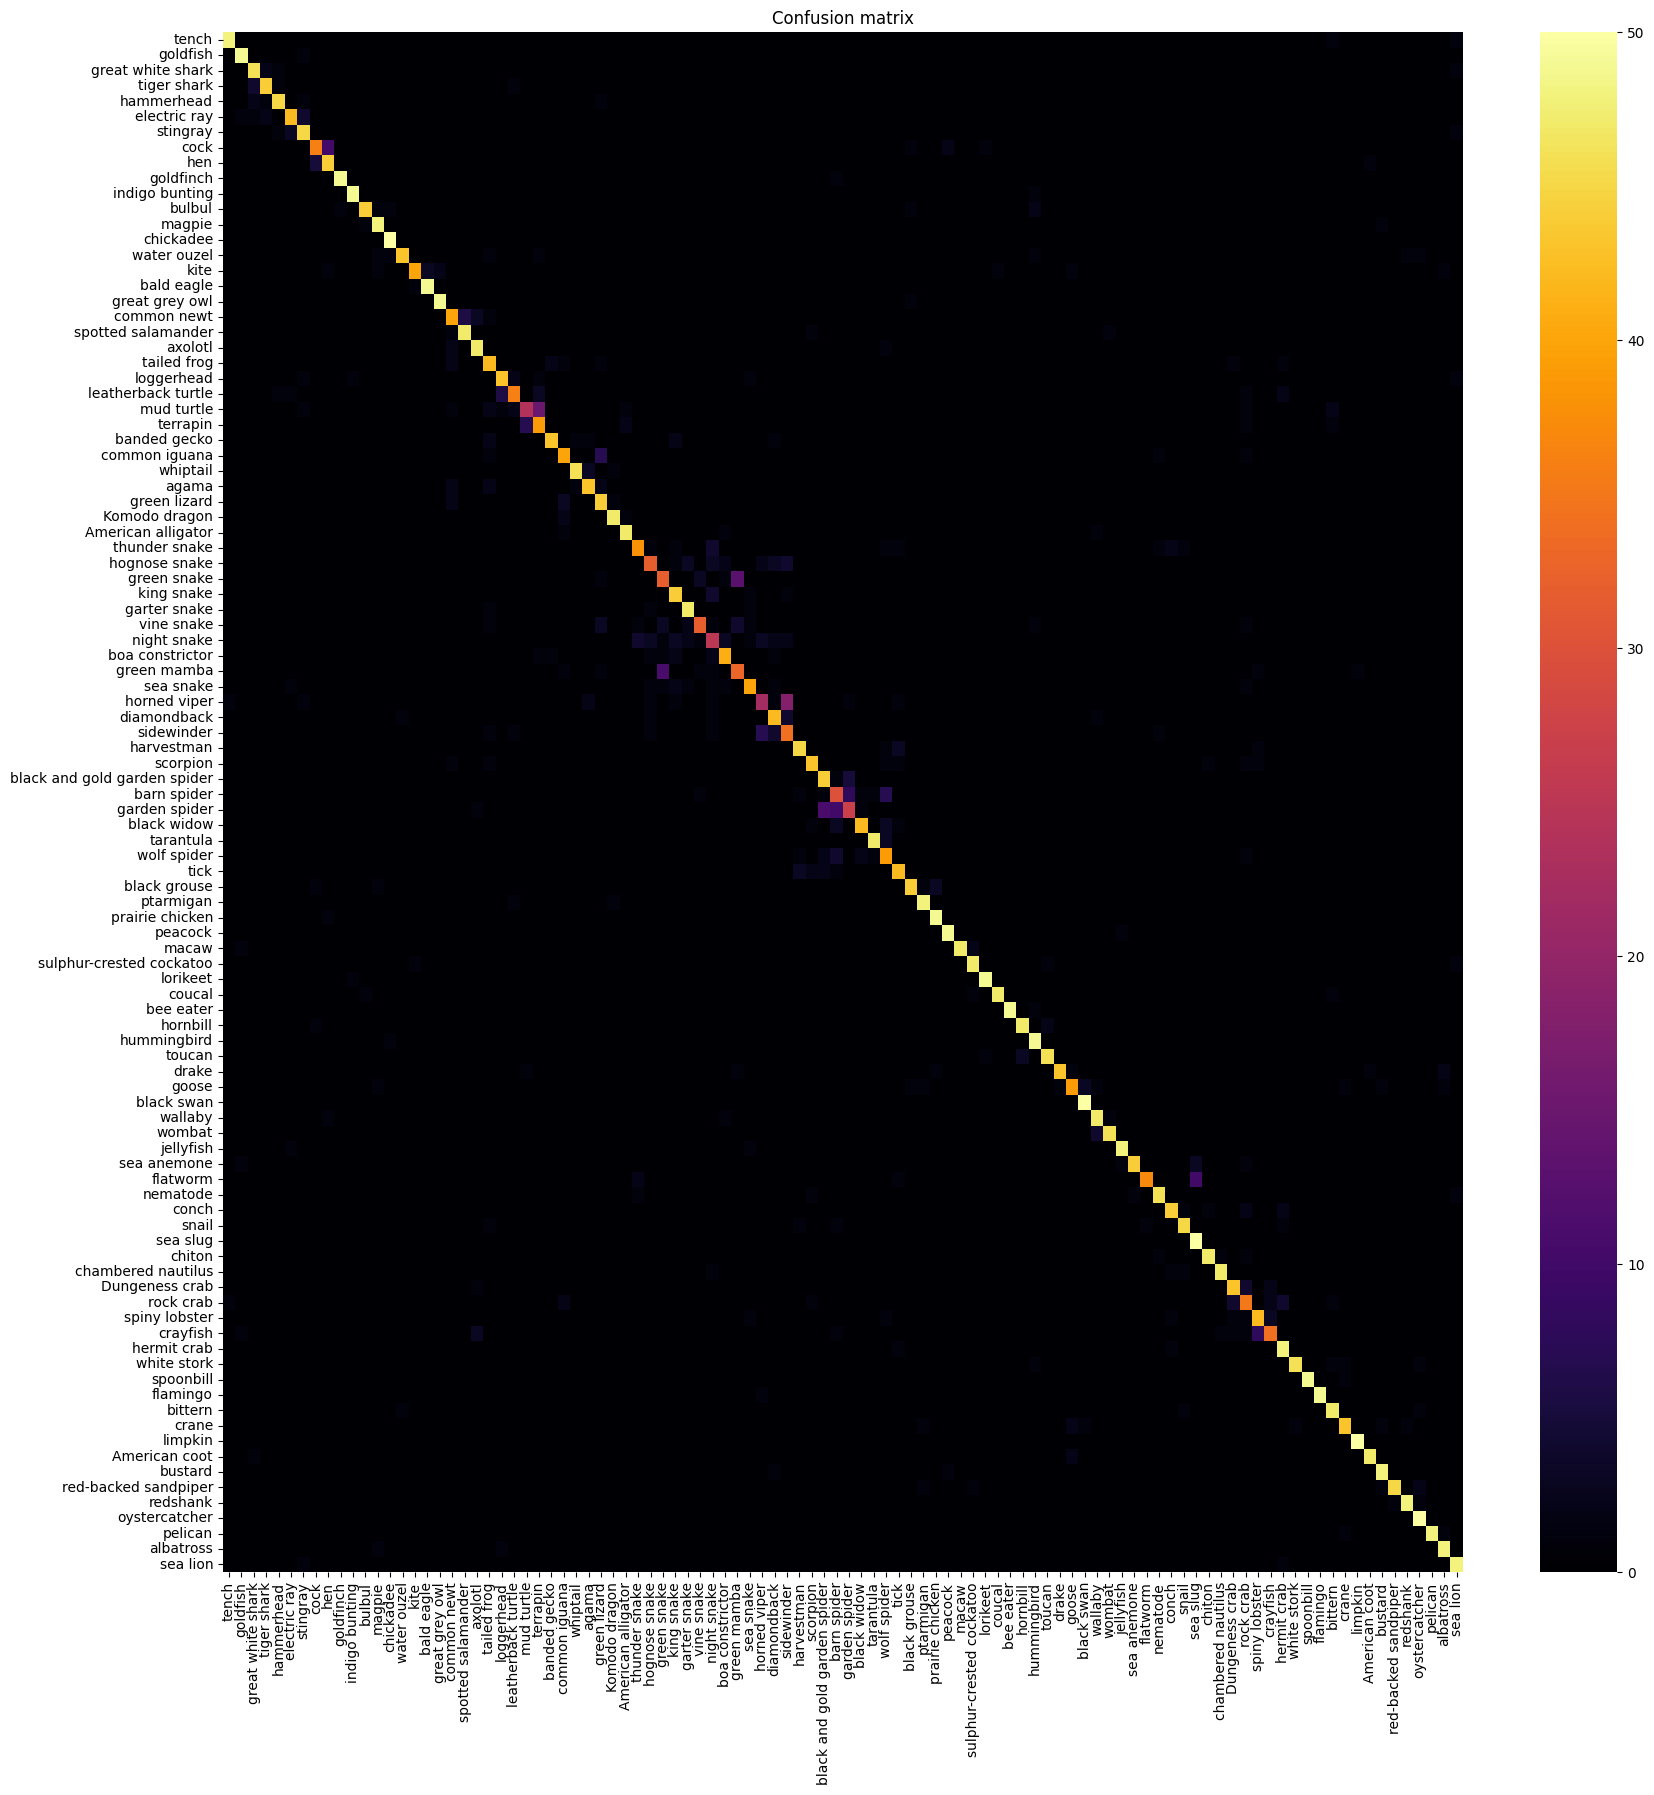

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

print("example of the cnn output showing probabilities:")
print(predictions[0])

final = np.argmax(predictions, axis=1) #converts row into single value of highest prob. index = class ID
real_labels = real_labels = val_gen.classes

indexed_items = list(val_gen.class_indices.keys())

named_index_items = [data.get(item, item).split(",")[0] for item in indexed_items]

print(classification_report(real_labels, final, target_names = named_index_items)) #classification report and confusion matrix

cm = confusion_matrix(real_labels, final)
plt.figure(figsize=(20, 20))
sns.heatmap(cm, fmt='d', cmap="inferno")
plt.title("Confusion matrix")
plt.xticks(np.arange(100) + 0.5, named_index_items, rotation=90)
plt.yticks(np.arange(100) + 0.5, named_index_items, rotation=0)
plt.show()

Text(0.5, 1.0, 'Misclassification report')

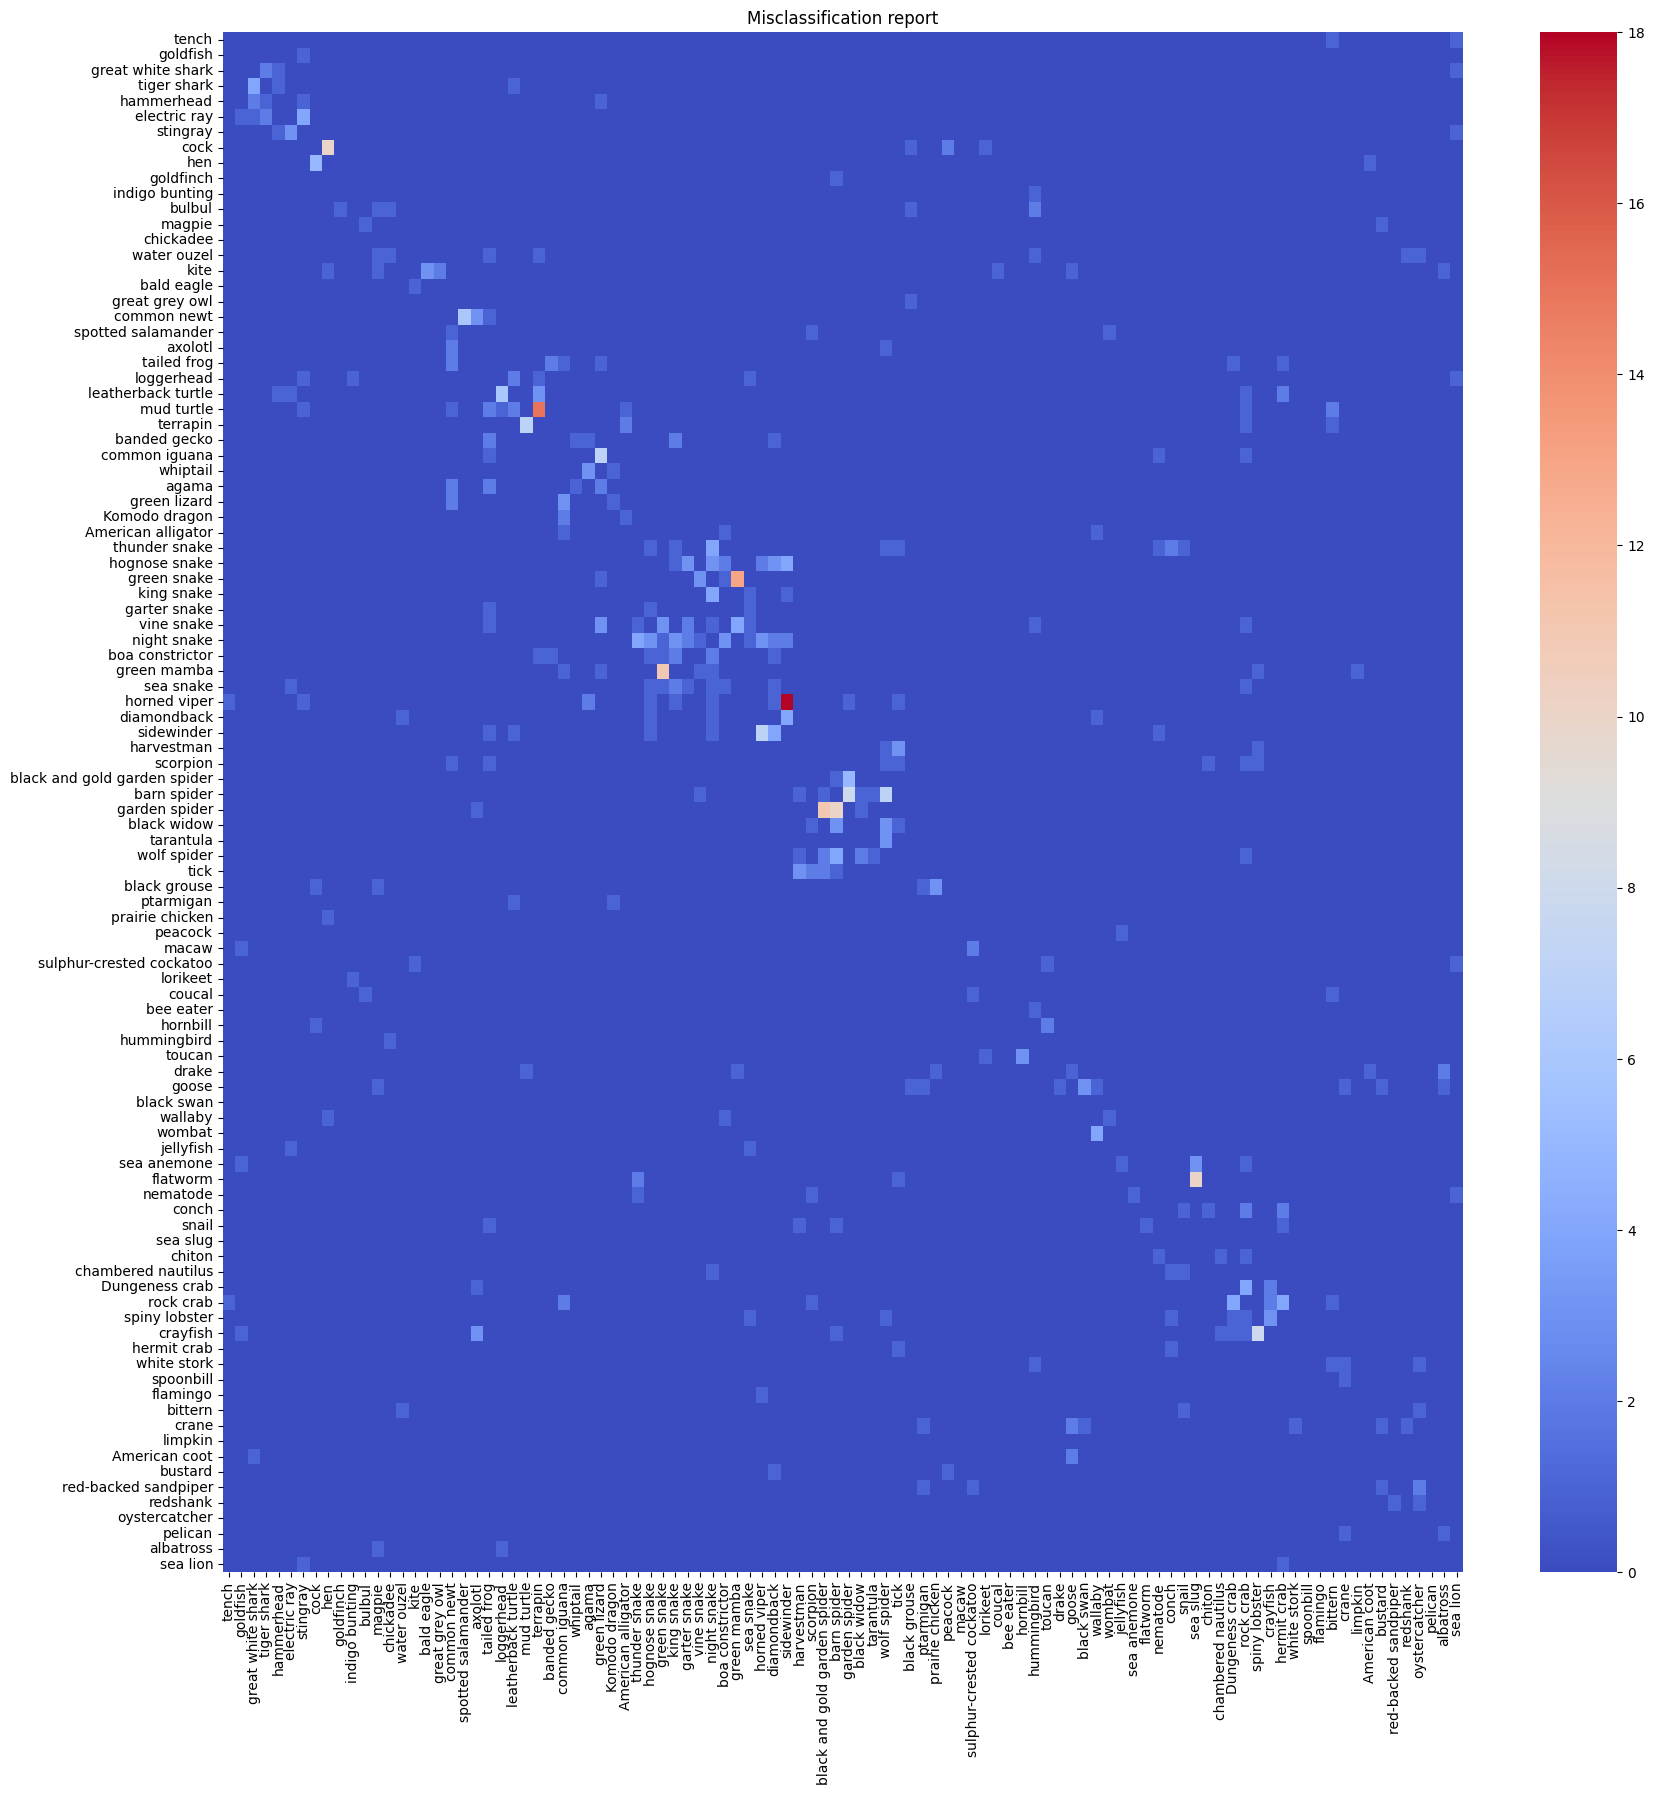

In [33]:
plt.figure(figsize=(20, 20))
np.fill_diagonal(cm, 0) #removing all correctly classified examples - in the diagonal
sns.heatmap(cm, cmap="coolwarm")
plt.xticks(np.arange(100) + 0.5, named_index_items, rotation=90)
plt.yticks(np.arange(100) + 0.5, named_index_items, rotation=0)
plt.title("Misclassification report")

horned vipers and sidewinders appear to have the highest confusion. note that most misclassifications have occured in semantically similar classes - eg. confusing 2 different kinds of snakes.

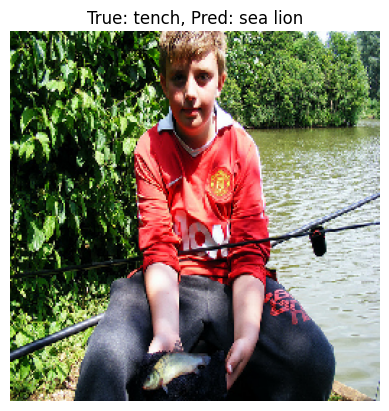

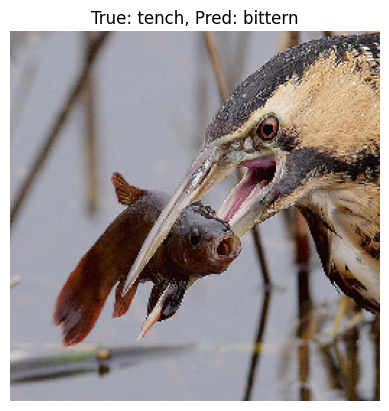

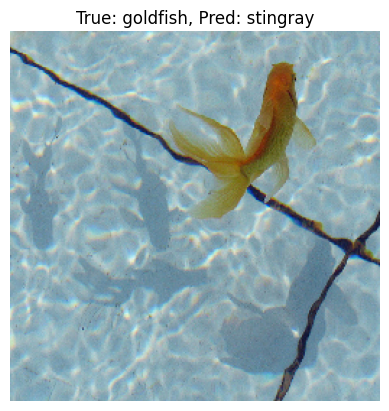

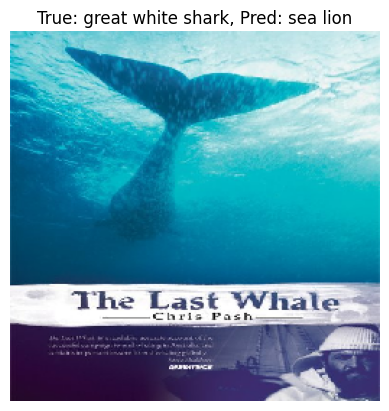

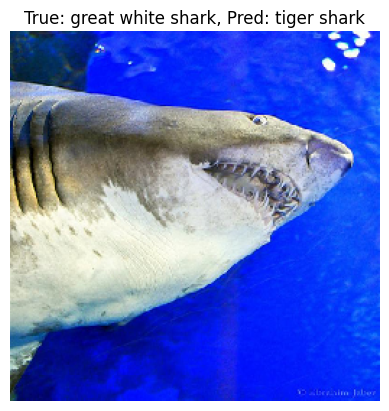

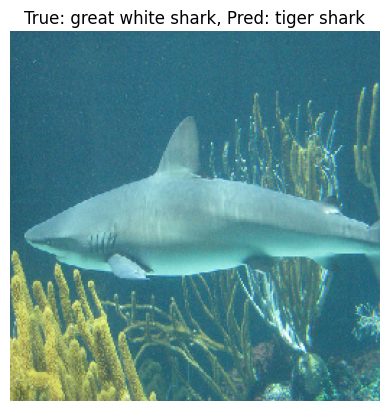

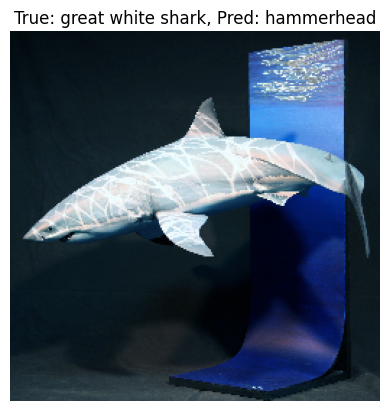

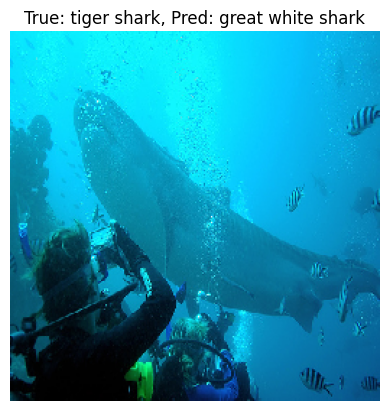

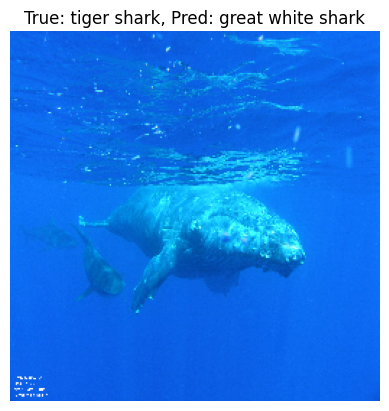

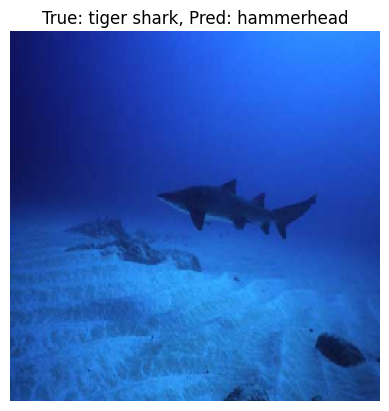

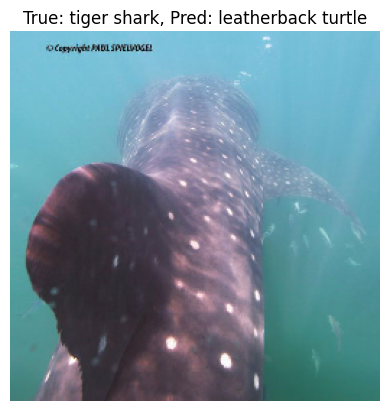

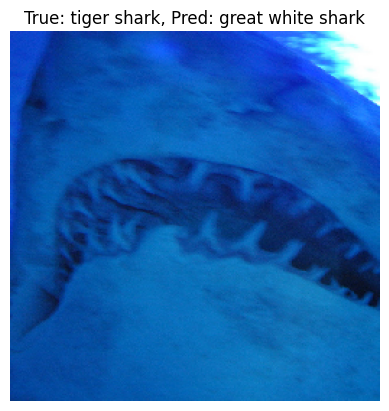

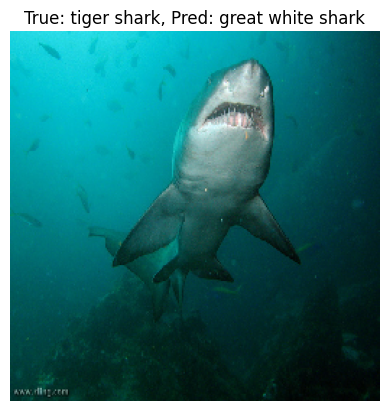

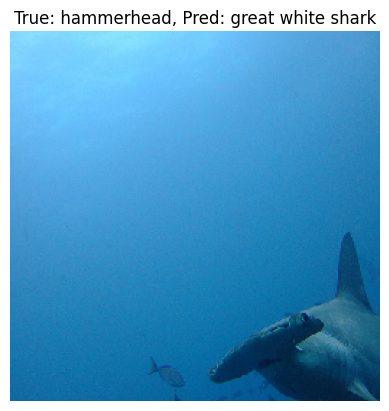

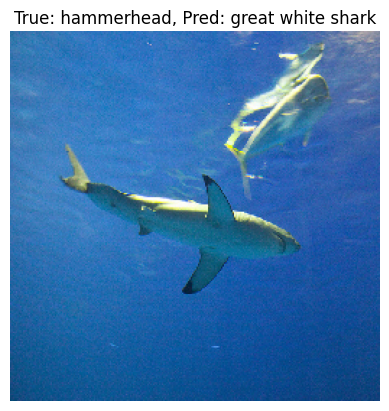

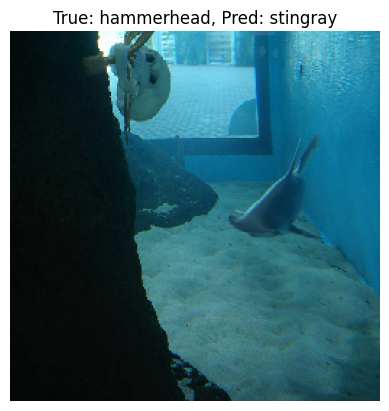

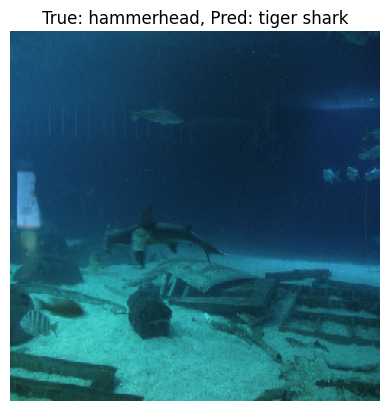

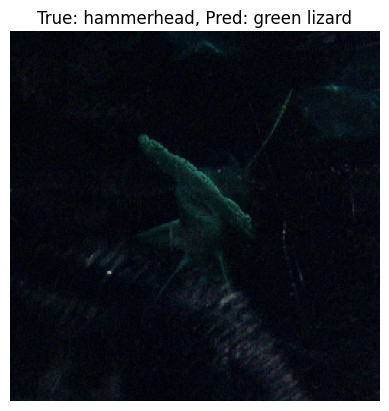

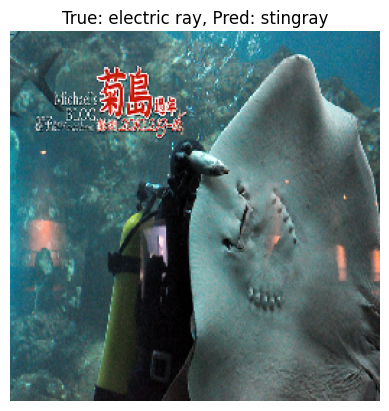

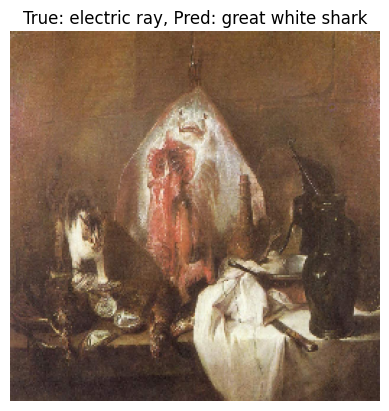

In [47]:
filenames = val_gen.filenames
errors = np.where(final != real_labels)[0]

for i in errors[:20]:
    # Load image using testing.directory + filenames[i]
    img_path = os.path.join(val_gen.directory, filenames[i])
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
    img_array = tf.keras.preprocessing.image.img_to_array(img).astype("uint8")
    
    plt.imshow(img_array.astype("uint8"))
    plt.title(f"True: {named_index_items[real_labels[i]]}, Pred: {named_index_items[final[i]]}")
    plt.axis("off")
    plt.show()

In [12]:
print(f"Matthew's Correlation Coefficient : {matthews_corrcoef(real_labels, final)}")
print(f"Accuracy : {accuracy_score(real_labels, final)}")
print(f"f1 score : {f1_score(real_labels, final, average='weighted')}")
print(f"Log loss : {log_loss(real_labels, predictions)}")
print(f"Recall : {recall_score(real_labels, final, average='weighted')}")
print(f"Precision : {precision_score(real_labels, final, average='weighted')}")

Matthew's Correlation Coefficient : 0.866917340685949
Accuracy : 0.8682
f1 score : 0.8669954605512934
Log loss : 0.6016908336857109
Recall : 0.8682
Precision : 0.8702944420752392


### The above scores show very decent model performance.

Accuracy, f1, recall and precision are very similar in value - showing a balanced model that generalises and predicts well. A low log loss and high MCC also show a confident model.

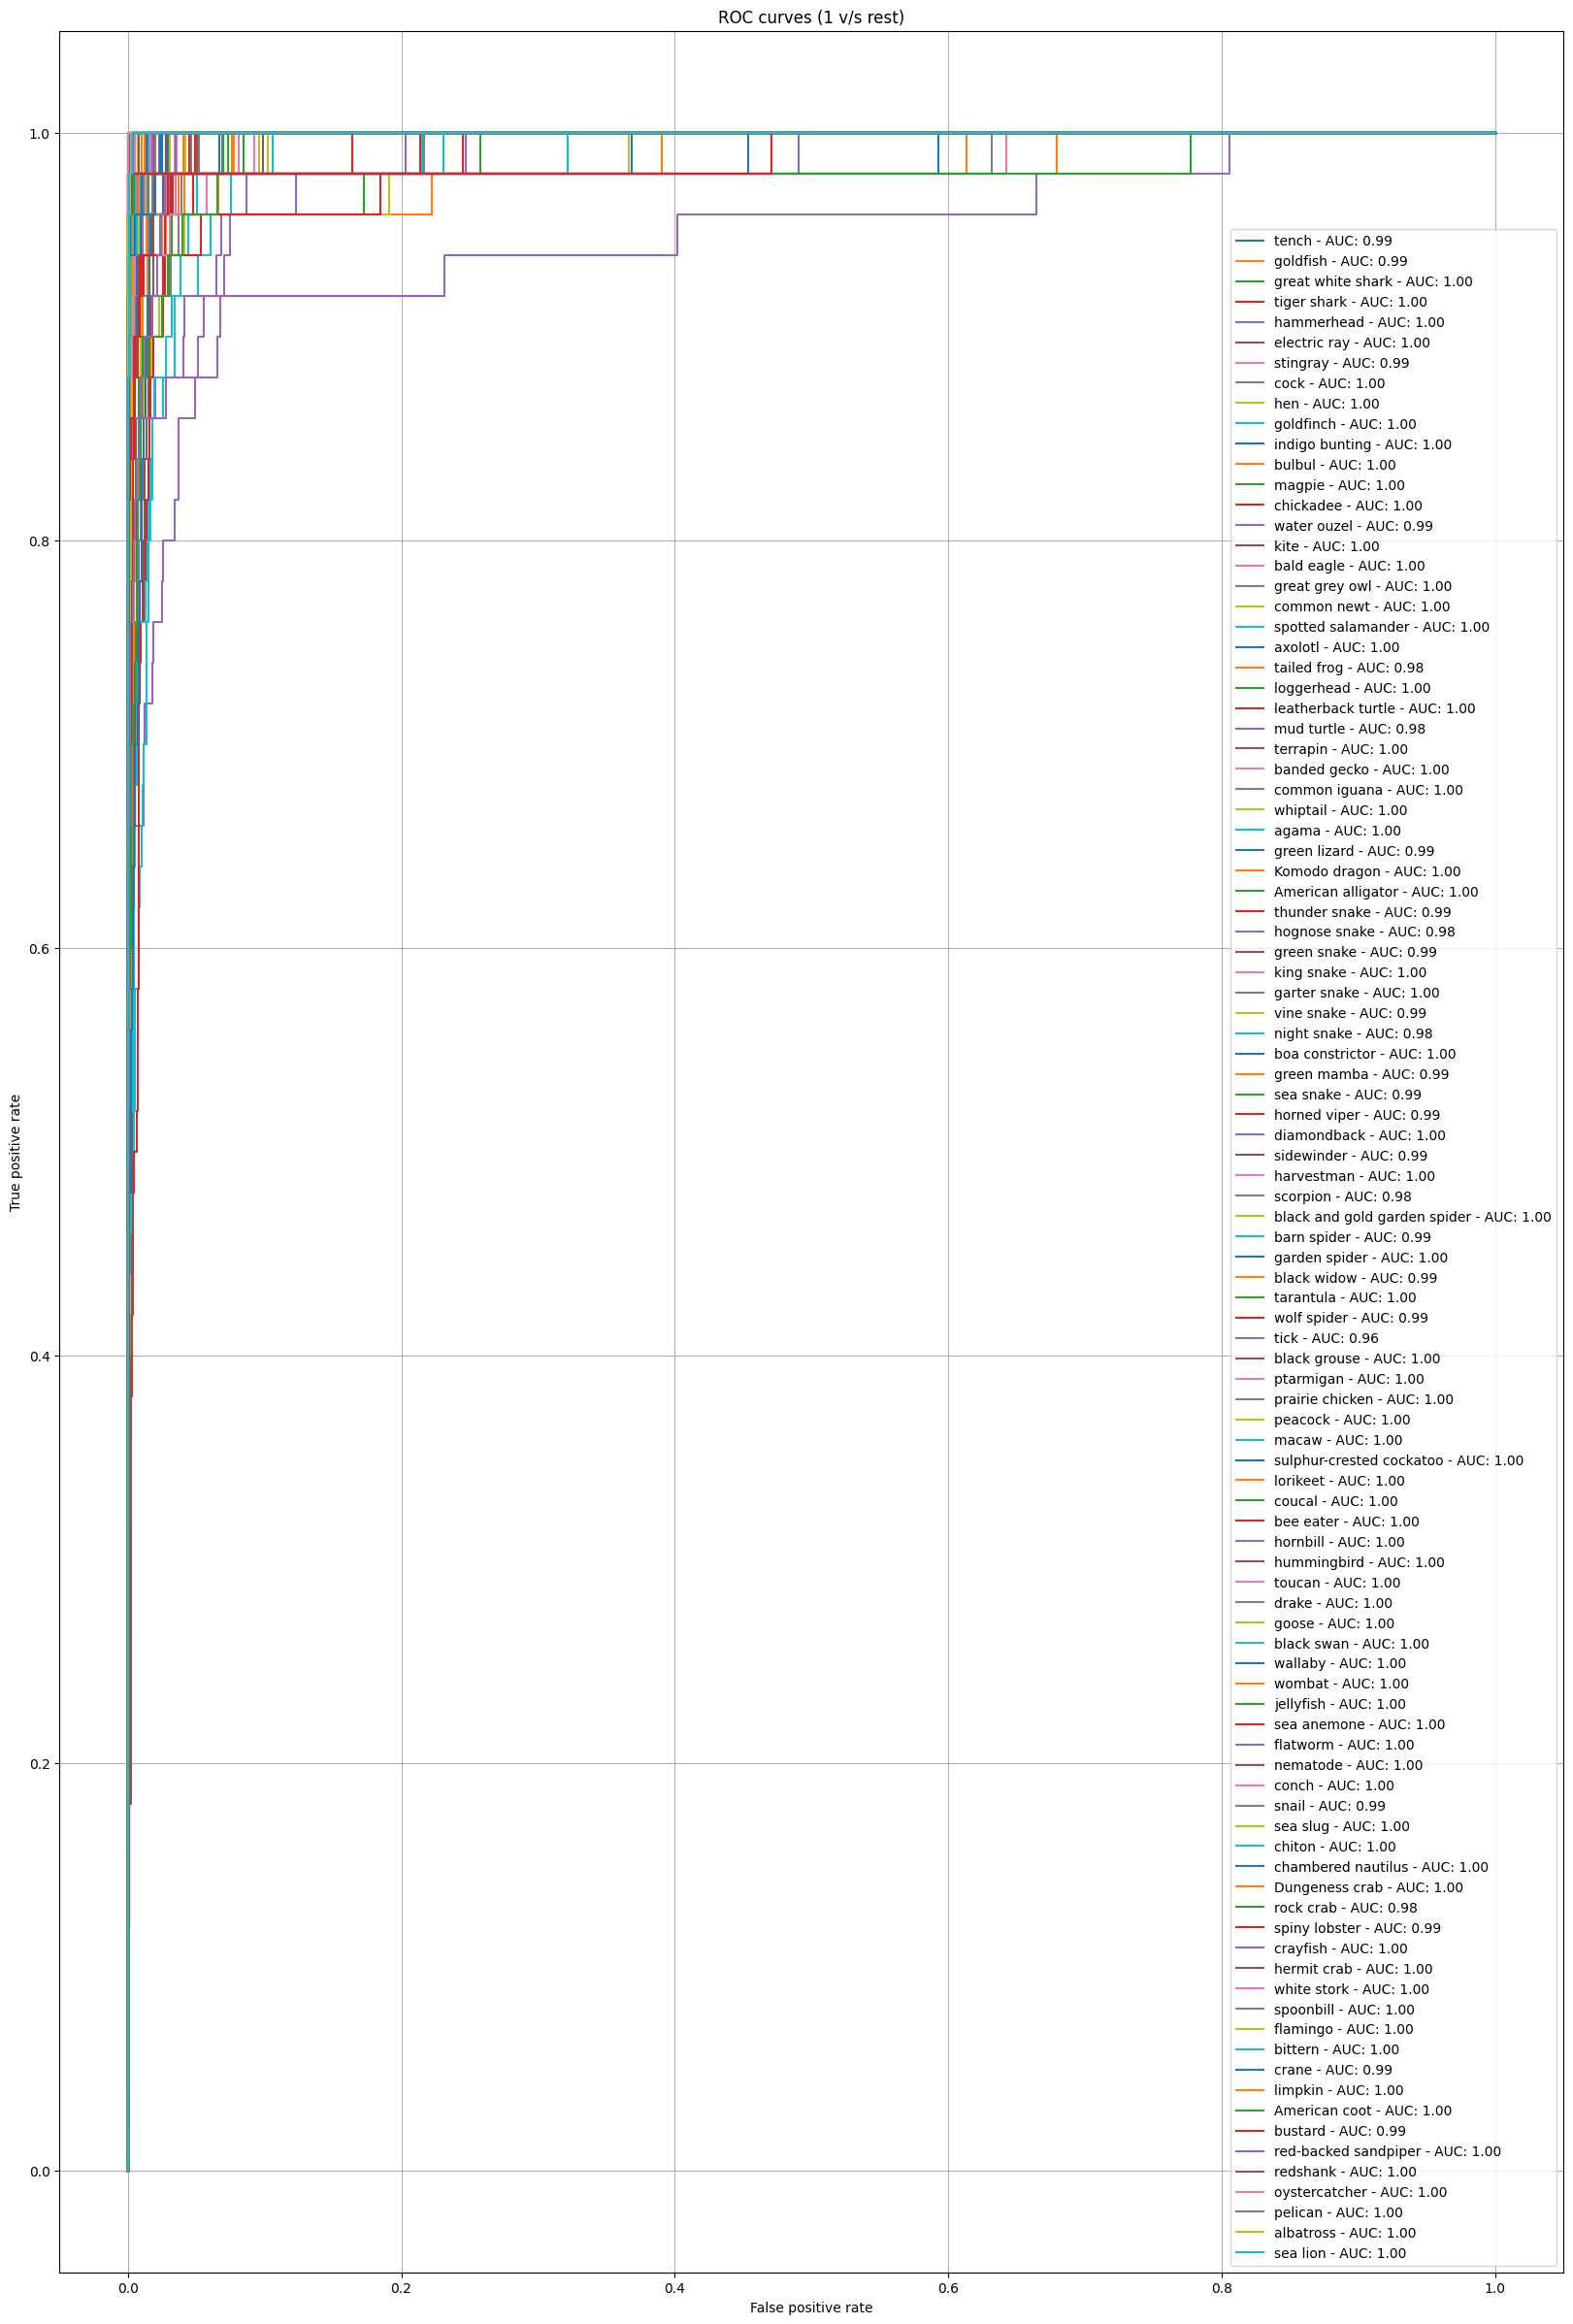

In [35]:
real_bin = label_binarize(real_labels, classes=np.arange(100))

plt.figure(figsize=(20,30))

for i in range(100):
    
    false_p_rate, true_p_rate, thresholds = roc_curve(real_bin[:, i], predictions[:, i])
    
    roc_auc = auc(false_p_rate, true_p_rate) #higher area under curve - straighter the lines - lesser the FPR
    
    plt.plot(false_p_rate, true_p_rate, label=f"{named_index_items[i]} - AUC: {roc_auc:.2f}")

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves (1 v/s rest)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## Conclusion

The uniformly high AUC scores, combined with an MCC score of 0.867, a top1 test accuracy of 86%, a low (0.6) log loss and f1, precision and recall scores around 86-87% show incredibly robust model performance.

The top-3 accuracy is outstanding at 99-96%. Most misclassifications are only slightly off and predicted as semantically similar classes. this shows rich feature knowledge and generalisations.

The ROC curve shows a high degree of separability and incredibly high AUC scores (lowest 0.98).

These statistics show that the ML model has achieved a high degree of confidence, feature richness, separability and accuracy in classifying imagenet-100.

Thus, the model solves the problem posed by the dataset.